In [31]:
! pip install liac-arff
! pip install pandas
! pip install numpy
! pip install matplotlib

In [2]:
import os
import glob
import csv
import arff  # module liac-arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pour afficher les graphiques dans le Notebook
%matplotlib inline

print("Dossier courant :", os.getcwd())

Dossier courant : c:\Users\henri\Desktop\test_ci\metrics\metrics


In [3]:
def extract_algorithm_name(file_path):
    """
    Extrait le nom de l'algorithme depuis le nom de fichier.
    Exemple : pour 'weka_experiment_tree_RandomForest_3.arff',
    on extrait 'tree_RandomForest_3'.
    Adaptable selon votre convention de nommage.
    """
    base = os.path.basename(file_path)
    if base.startswith("weka_experiment_"):
        algo = base.replace("weka_experiment_", "").replace(".arff", "")
    else:
        algo = base.replace(".arff", "")
    return algo

def parse_arff_file(filepath):
    """
    Parser alternatif pour un fichier ARFF.
    Lit le fichier en texte et extrait :
      - La relation (@relation)
      - La liste des attributs (@attribute)
      - Les lignes de données (après la ligne @data)
    Attention, ce parser utilise un découpage simple par virgule pour les données.
    """
    attributes = []
    data = []
    relation = None
    header_ended = False
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('%'):  # ignorer les lignes vides ou commentaires
                continue
            lower = line.lower()
            if not header_ended:
                if lower.startswith('@relation'):
                    parts = line.split()
                    if len(parts) >= 2:
                        relation = parts[1]
                elif lower.startswith('@attribute'):
                    # On suppose que la ligne est du type: @attribute <name> <type>
                    parts = line.split(None, 2)
                    if len(parts) >= 2:
                        attr_name = parts[1]
                        attributes.append(attr_name)
                elif lower.startswith('@data'):
                    header_ended = True
            else:
                # On découpe la ligne par virgule (attention : si des valeurs contiennent des virgules, il faudra adapter)
                if line:
                    row = line.split(',')
                    data.append(row)
    return {"relation": relation, "attributes": attributes, "data": data}

def convert_arff_to_csv(arff_file, output_dir):
    """
    Convertit un fichier ARFF en CSV en ajoutant une colonne 'Algorithm'
    contenant le nom extrait du fichier.
    D'abord, on tente d'utiliser arff.load() sur le chemin ; si le résultat ne contient pas
    la clé "attributes", on utilise un parser alternatif.
    """
    try:
        # Essai : utilisation du module arff en passant le chemin directement
        arff_gen = arff.load(arff_file)
        arff_data = next(arff_gen)
    except Exception as e:
        print(f"Erreur lors de l'utilisation de arff.load sur {arff_file}: {e}")
        arff_data = None

    if (arff_data is None) or ("attributes" not in arff_data):
        print(f"Avertissement : la structure retournée par arff.load ne contient pas 'attributes'. " 
              f"Utilisation du parser alternatif pour {arff_file}.")
        arff_data = parse_arff_file(arff_file)
    
    # On attend que le dictionnaire contienne "attributes" et "data"
    try:
        attributes = arff_data["attributes"]
        data_rows = arff_data["data"]
    except KeyError as ke:
        raise ValueError(f"Le fichier ARFF '{arff_file}' n'a pas une structure attendue. Dictionnaire lu: {list(arff_data.keys())}") from ke
    
    # Extraction du nom de l'algorithme depuis le nom du fichier
    algo_name = extract_algorithm_name(arff_file)
    
    # Prépare le header en ajoutant une colonne 'Algorithm'
    header = attributes + ["Algorithm"]
    
    # Détermine le nom du fichier CSV de sortie (conserve le nom de base)
    base_csv = os.path.basename(arff_file).replace(".arff", ".csv")
    output_csv = os.path.join(output_dir, base_csv)
    
    # Écriture du fichier CSV
    with open(output_csv, "w", newline="", encoding="utf-8") as f_out:
        writer = csv.writer(f_out)
        writer.writerow(header)
        for row in data_rows:
            # On ajoute dans chaque ligne le nom de l'algorithme
            row_extended = row + [algo_name]
            writer.writerow(row_extended)
    
    print(f"Création du fichier CSV : {output_csv}")
    return output_csv

In [4]:
# Définir les chemins relatifs
arff_dir = os.path.join(os.getcwd(), "weka-files")
csv_dir = os.path.join(os.getcwd(), "csv-files")
os.makedirs(csv_dir, exist_ok=True)

# Recherche de tous les fichiers ARFF dans le dossier
arff_files = glob.glob(os.path.join(arff_dir, "*.arff"))
print(f"Nombre de fichiers ARFF trouvés : {len(arff_files)}")

# Conversion de chaque fichier ARFF en CSV
csv_files = []
for arff_file in arff_files:
    csv_out = convert_arff_to_csv(arff_file, csv_dir)
    csv_files.append(csv_out)

Nombre de fichiers ARFF trouvés : 5
Erreur lors de l'utilisation de arff.load sur c:\Users\henri\Desktop\test_ci\metrics\metrics\weka-files\weka_experiment_bayes.arff: Invalid layout of the ARFF file, at line 1.
Avertissement : la structure retournée par arff.load ne contient pas 'attributes'. Utilisation du parser alternatif pour c:\Users\henri\Desktop\test_ci\metrics\metrics\weka-files\weka_experiment_bayes.arff.
Création du fichier CSV : c:\Users\henri\Desktop\test_ci\metrics\metrics\csv-files\weka_experiment_bayes.csv
Erreur lors de l'utilisation de arff.load sur c:\Users\henri\Desktop\test_ci\metrics\metrics\weka-files\weka_experiment_lazy_IBk.arff: Invalid layout of the ARFF file, at line 1.
Avertissement : la structure retournée par arff.load ne contient pas 'attributes'. Utilisation du parser alternatif pour c:\Users\henri\Desktop\test_ci\metrics\metrics\weka-files\weka_experiment_lazy_IBk.arff.
Création du fichier CSV : c:\Users\henri\Desktop\test_ci\metrics\metrics\csv-files\

In [5]:
# Charger tous les CSV dans une liste de DataFrames et les concaténer
df_list = [pd.read_csv(f) for f in csv_files]
df_all = pd.concat(df_list, ignore_index=True)
print("Dimensions du DataFrame global :", df_all.shape)
display(df_all.head())

# Appliquer un filtre :
# Pour les lignes dont Key_Scheme contient "Bayes" (insensible à la casse), 
# exclure celles dont Key_Scheme_options est vide, c'est-à-dire 
# null, vide ou égale à "''".
mask = ~(
    (df_all["Key_Scheme"].str.contains("Bayes", case=False)) &
    (
        df_all["Key_Scheme_options"].isnull() |
        (df_all["Key_Scheme_options"].str.strip() == "") |
        (df_all["Key_Scheme_options"].str.strip() == "''")
    )
)
df_all = df_all.loc[mask].copy()
print("Dimensions après filtrage Bayes :", df_all.shape)
display(df_all.head())

# Liste des colonnes à convertir en numérique (adaptez cette liste selon vos fichiers)
numeric_cols = [
    "Percent_correct", "Kappa_statistic", "IR_precision", "IR_recall",
    "Mean_absolute_error", "Root_mean_squared_error", "False_positive_rate",
    "False_negative_rate", "Area_under_ROC", "Area_under_PRC",
    "Relative_absolute_error", "Root_relative_squared_error", "Elapsed_Time_training", "F_measure"
]

# Conversion en types numériques si la colonne existe
for col in numeric_cols:
    if col in df_all.columns:
        df_all.loc[:, col] = pd.to_numeric(df_all.loc[:, col], errors='coerce')
    else:
        print(f"Attention : la colonne '{col}' n'est pas présente.")

# Calcul des ratios si possible
if "False_positive_rate" in df_all.columns and "False_negative_rate" in df_all.columns:
    df_all.loc[:, "FP_FN_ratio"] = df_all["False_positive_rate"] / df_all["False_negative_rate"]
else:
    print("Les colonnes nécessaires pour FP_FN_ratio sont manquantes.")

if "Relative_absolute_error" in df_all.columns and "Root_relative_squared_error" in df_all.columns:
    df_all.loc[:, "RAE_RRSE_ratio"] = df_all["Relative_absolute_error"] / df_all["Root_relative_squared_error"]
else:
    print("Les colonnes nécessaires pour RAE_RRSE_ratio sont manquantes.")

display(df_all.head())

Dimensions du DataFrame global : (340, 81)


,Key_Dataset,Key_Run,Key_Fold,Key_Scheme,Key_Scheme_options,Key_Scheme_version_ID,Date_time,Number_of_training_instances,Number_of_testing_instances,Number_correct,...,measureBayesScore,measureBDeuScore,measureMDLScore,measureAICScore,measureEntropyScore,Algorithm,measureTreeSize,measureNumLeaves,measureNumRules,measureOutOfBagError
0,merged_dataset,1,1,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15158,...,-2065665.604513,-2559920.449017,-2433188.35431,-2250066.935244,-2212841.935244,bayes,NaN,NaN,NaN,NaN
1,merged_dataset,1,2,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15153,...,-2051590.112513,-2545899.60903,-2419181.64536,-2236025.791105,-2198793.791105,bayes,NaN,NaN,NaN,NaN
2,merged_dataset,1,3,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15152,...,-2066053.141688,-2560362.638205,-2433629.803625,-2250473.94937,-2213241.94937,bayes,NaN,NaN,NaN,NaN
3,merged_dataset,1,4,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15154,...,-2065629.623513,-2559939.12003,-2433218.805263,-2250062.951007,-2212830.951007,bayes,NaN,NaN,NaN,NaN
4,merged_dataset,1,5,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15129,...,-2065645.664128,-2559955.160645,-2433231.001537,-2250075.147281,-2212843.147281,bayes,NaN,NaN,NaN,NaN


Dimensions après filtrage Bayes : (240, 81)


,Key_Dataset,Key_Run,Key_Fold,Key_Scheme,Key_Scheme_options,Key_Scheme_version_ID,Date_time,Number_of_training_instances,Number_of_testing_instances,Number_correct,...,measureBayesScore,measureBDeuScore,measureMDLScore,measureAICScore,measureEntropyScore,Algorithm,measureTreeSize,measureNumLeaves,measureNumRules,measureOutOfBagError
0,merged_dataset,1,1,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15158,...,-2065665.604513,-2559920.449017,-2433188.35431,-2250066.935244,-2212841.935244,bayes,NaN,NaN,NaN,NaN
1,merged_dataset,1,2,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15153,...,-2051590.112513,-2545899.60903,-2419181.64536,-2236025.791105,-2198793.791105,bayes,NaN,NaN,NaN,NaN
2,merged_dataset,1,3,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15152,...,-2066053.141688,-2560362.638205,-2433629.803625,-2250473.94937,-2213241.94937,bayes,NaN,NaN,NaN,NaN
3,merged_dataset,1,4,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15154,...,-2065629.623513,-2559939.12003,-2433218.805263,-2250062.951007,-2212830.951007,bayes,NaN,NaN,NaN,NaN
4,merged_dataset,1,5,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15129,...,-2065645.664128,-2559955.160645,-2433231.001537,-2250075.147281,-2212843.147281,bayes,NaN,NaN,NaN,NaN


,Key_Dataset,Key_Run,Key_Fold,Key_Scheme,Key_Scheme_options,Key_Scheme_version_ID,Date_time,Number_of_training_instances,Number_of_testing_instances,Number_correct,...,measureMDLScore,measureAICScore,measureEntropyScore,Algorithm,measureTreeSize,measureNumLeaves,measureNumRules,measureOutOfBagError,FP_FN_ratio,RAE_RRSE_ratio
0,merged_dataset,1,1,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15158,...,-2433188.35431,-2250066.935244,-2212841.935244,bayes,NaN,NaN,NaN,NaN,0.002053,0.715927
1,merged_dataset,1,2,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15153,...,-2419181.64536,-2236025.791105,-2198793.791105,bayes,NaN,NaN,NaN,NaN,0.003369,0.724619
2,merged_dataset,1,3,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15152,...,-2433629.803625,-2250473.94937,-2213241.94937,bayes,NaN,NaN,NaN,NaN,0.001619,0.731982
3,merged_dataset,1,4,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15154,...,-2433218.805263,-2250062.951007,-2212830.951007,bayes,NaN,NaN,NaN,NaN,0.002086,0.722079
4,merged_dataset,1,5,weka.classifiers.bayes.BayesNet,'-D -Q weka.classifiers.bayes.net.search.local...,746037443258775954,2.025040e+07,138500,15389,15129,...,-2433231.001537,-2250075.147281,-2212843.147281,bayes,NaN,NaN,NaN,NaN,0.002294,0.739553


In [6]:
# Dictionnaire des métriques à comparer (modifiez si besoin)
metrics = {
    "Accuracy": "Percent_correct",
    "Kappa": "Kappa_statistic",
    "Precision": "IR_precision",
    "Recall": "IR_recall",
    "MAE": "Mean_absolute_error",
    "RMSE": "Root_mean_squared_error",
    "FP Rate": "False_positive_rate",
    "ROC-AUC": "Area_under_ROC",
    "FP Rate / FN Rate": "FP_FN_ratio",
    "PRC Area": "Area_under_PRC",
    "RAE / RRSE": "RAE_RRSE_ratio",
    "F_measure": "F_measure",
    "Learning Time": "Elapsed_Time_training"
}

# Sélectionner uniquement les colonnes existantes
metric_cols = [col for col in metrics.values() if col in df_all.columns]

# Groupement par 'Algorithm' puis calcul des moyennes
grouped_algo = df_all.groupby("Algorithm")[metric_cols].mean().round(2)
print("Statistiques moyennes par algorithme:")
display(grouped_algo)

Statistiques moyennes par algorithme:


,Percent_correct,Kappa_statistic,IR_precision,IR_recall,Mean_absolute_error,Root_mean_squared_error,False_positive_rate,Area_under_ROC,FP_FN_ratio,Area_under_PRC,RAE_RRSE_ratio,F_measure,Elapsed_Time_training
Algorithm,,,,,,,,,,,,,
bayes,98.99,0.70,0.833299,0.48,0.00,0.04,0.0,1.00,0.00,0.84,0.59,0.601233,0.42
lazy_IBk,99.19,0.79,0.602817,0.60,0.00,0.05,0.0,0.94,0.01,0.38,0.32,0.601003,0.04
tree_J48,99.94,0.98,0.996938,1.00,0.00,0.01,0.0,1.00,inf,1.00,0.27,0.997885,0.43
tree_REPTree,99.77,0.87,0.799882,0.80,0.00,0.01,0.0,0.99,inf,0.81,0.48,0.799304,1.75
tree_RandomForest,98.36,0.26,0.333333,0.03,0.01,0.05,0.0,1.00,0.00,0.79,0.88,0.147179,115.14


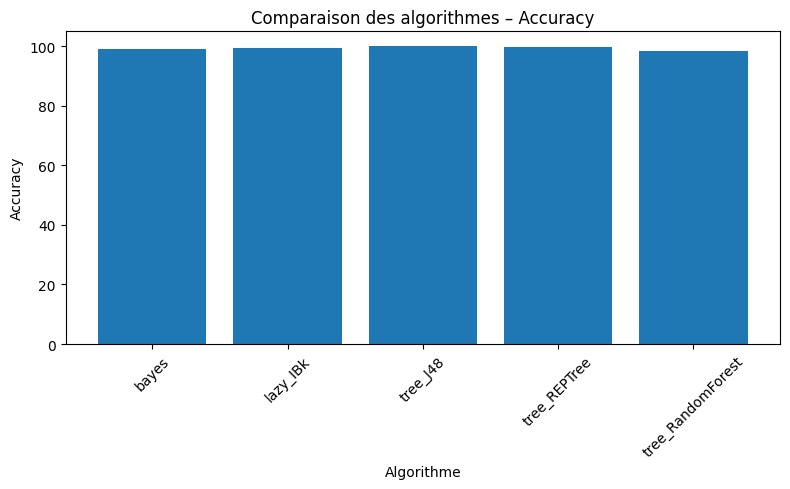

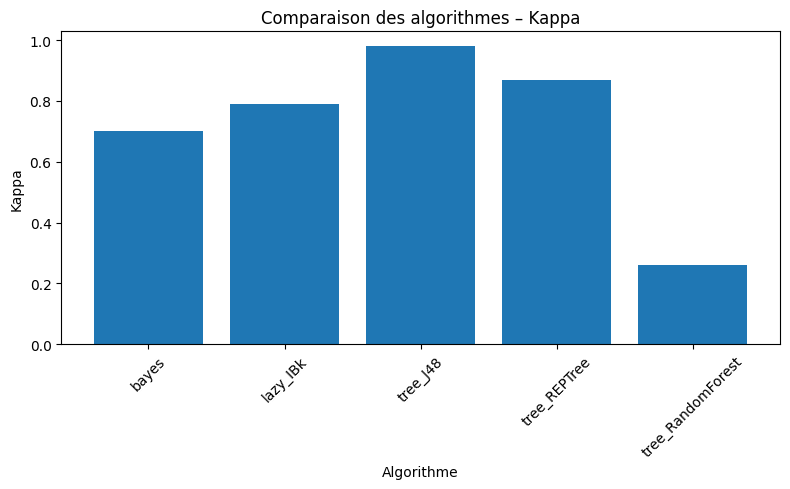

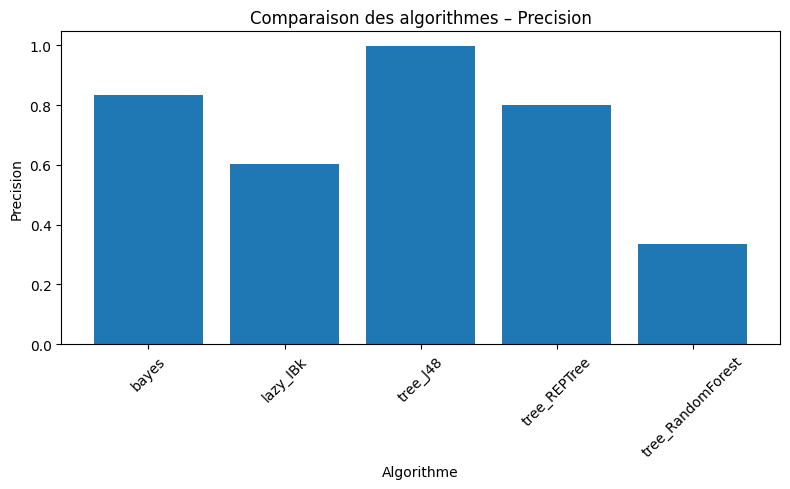

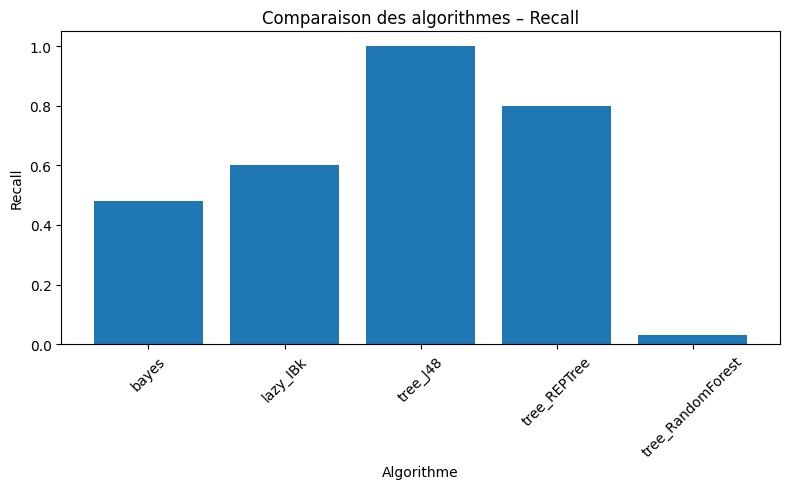

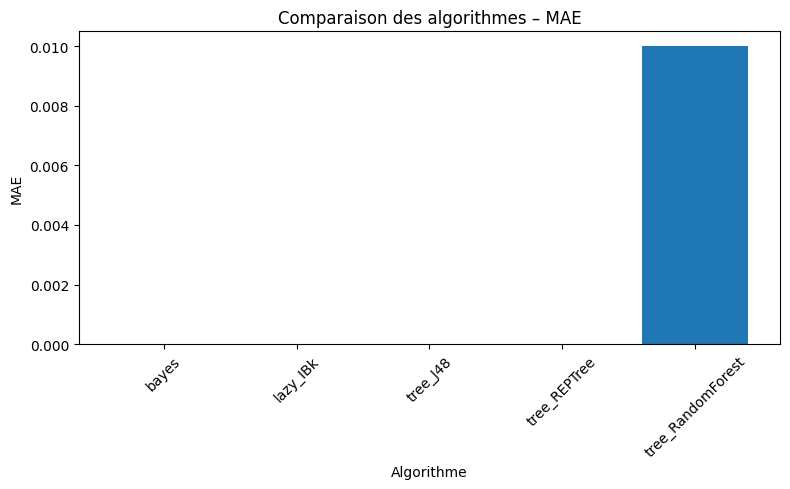

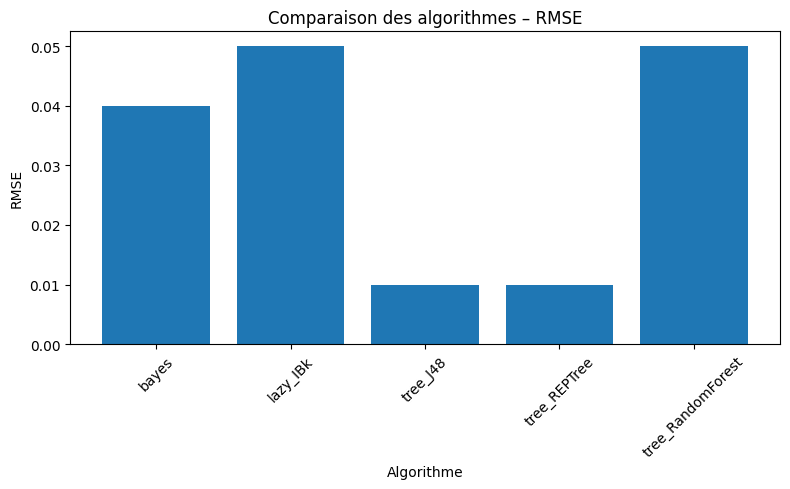

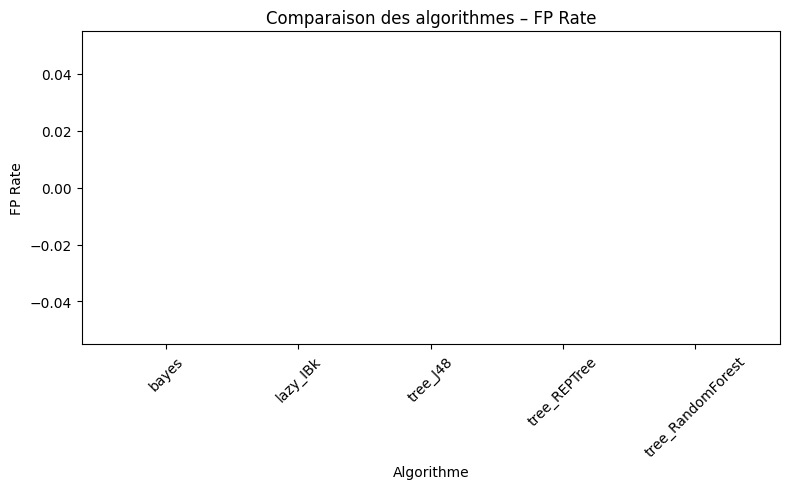

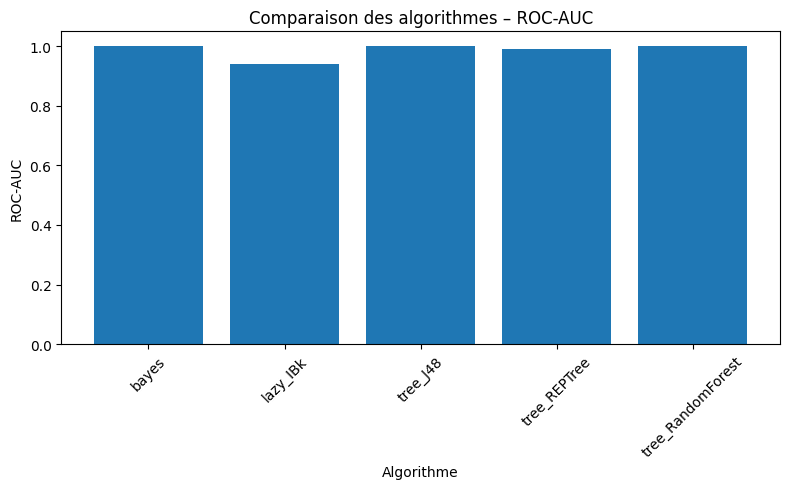

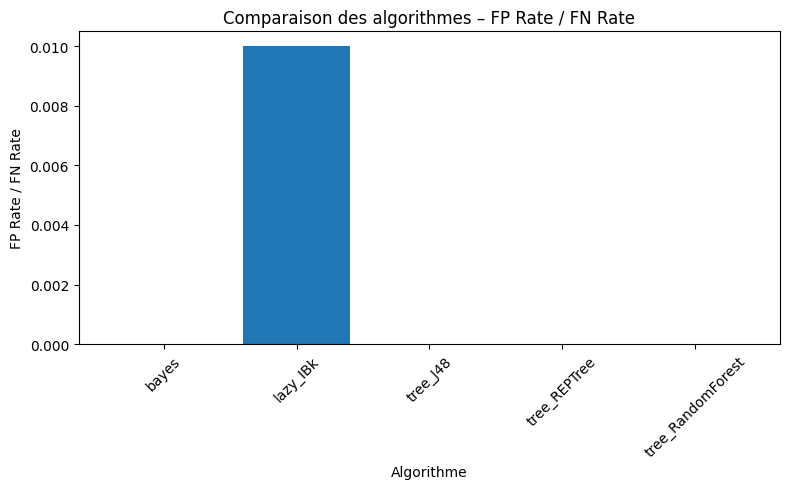

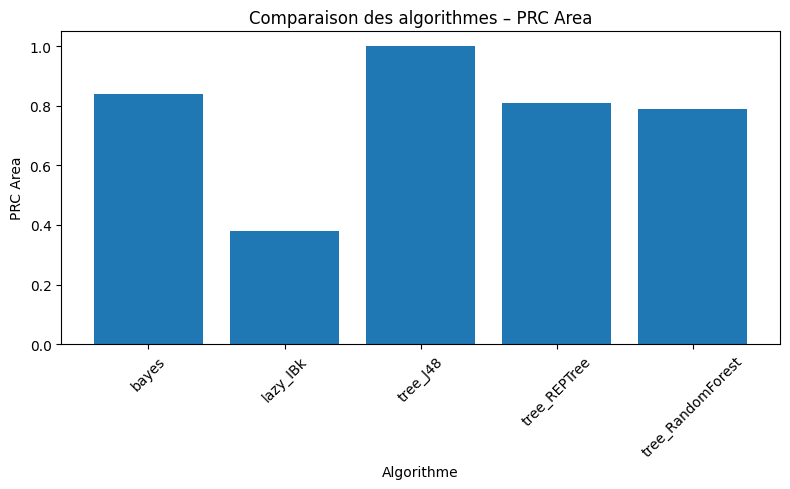

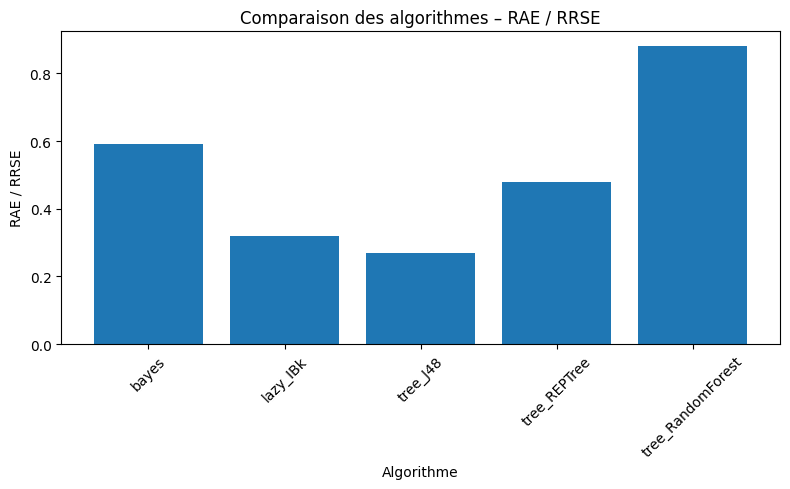

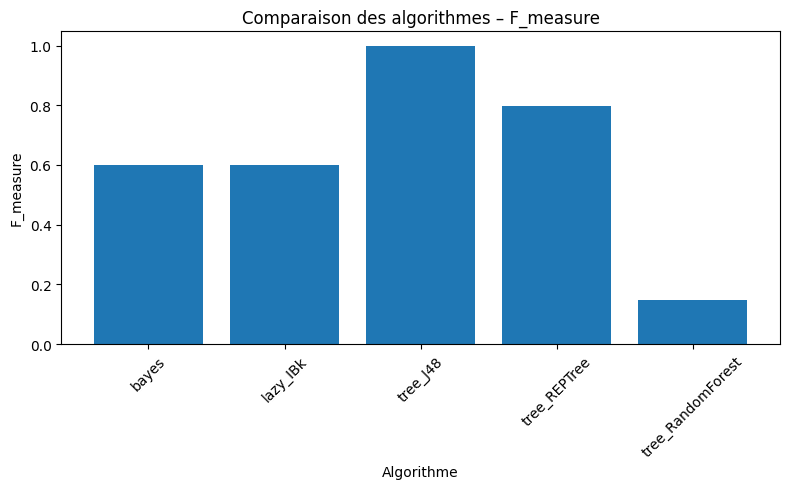

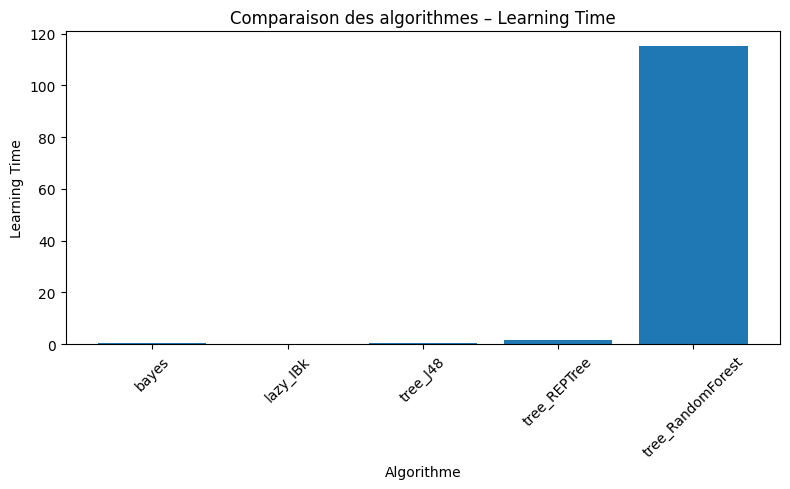

In [12]:
for metric_name, col in metrics.items():
    if col in grouped_algo.columns:
        plt.figure(figsize=(8, 5))
        plt.bar(grouped_algo.index, grouped_algo[col])
        plt.title(f"Comparaison des algorithmes – {metric_name}")
        plt.xlabel("Algorithme")
        plt.ylabel(metric_name)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()